In [5]:
import os

import numpy as np
import pandas as pd
import pickle 
from tqdm import tqdm

from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score

#keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU, Input, Flatten, concatenate
from keras import Model
from keras.metrics import RootMeanSquaredError


# Plots
import matplotlib.pyplot as plt

# Prerocessing for FEDOT
from fedot.core.data.data import InputData
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.api.main import Fedot
from fedot.core.repository.tasks import Task, TaskTypesEnum
# FEDOT 
from fedot.core.pipelines.pipeline import Pipeline

import logging
logging.raiseExceptions = False
import datetime

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

## Dataset general preparation

In [6]:
df = None
with open("covid_flow.pkl", "rb") as f:
    df = pickle.load(f)
df["case"] = df.index
df["t_point"] = df["t_point"].apply(lambda x: x[2:])
df["t_point"] = df["t_point"].apply(lambda x: int(x))
df = df.set_index(["case", "t_point"])
df = df.sort_values(["case", "t_point"])
dynamic_idx = list(range(29, 42))
dynamic_columns = list(df.columns[dynamic_idx])
df.loc[:, dynamic_columns]
full_df = df.copy()
full_df

омепразол_stat_control  надропарин кальция_stat_control  \
case    t_point                                                            
GACAAcY 0                             1                                1   
        1                             1                                1   
        2                             1                                1   
        3                             1                                1   
GACAAnf 0                             1                                1   
...                                 ...                              ...   
GACBB;O 0                             0                                0   
        1                             0                                0   
GACXAAB 0                             1                                0   
        1                             1                                0   
        2                             1                                0   

                 эзомепразол_stat_control  амлодипин_stat_control  \
case    t_point                                                     
GACAAcY 0                               1                       1   
        1                               1                       1   
        2                               1                       1   
        3                               1                       1   
GACAAnf 0                               1                       1   
...                                   ...                     ...   
GACBB;O 0                               0                       1   
        1                               0                       1   
GACXAAB 0                               1                       1   
        1                               1                       1   
        2                               1                       1   

                 амброксол_stat_control  домперидон_stat_control  \
case    t_point                                                    
GACAAcY 0                             1                        1   
        1                             1                        1   
        2                             1                        1   
        3                             1                        1   
GACAAnf 0                             1                        1   
...                                 ...                      ...   
GACBB;O 0                             1                        0   
        1                             1                        0   
GACXAAB 0                             0                        1   
        1                             0                        1   
        2                             0                        1   

                 меброфенин_stat_control  технеций_stat_control  \
case    t_point                                                   
GACAAcY 0                              1                      1   
        1                              1                      1   
        2                              1                      1   
        3                              1                      1   
GACAAnf 0                              1                      1   
...                                  ...                    ...   
GACBB;O 0                              0                      0   
        1                              0                      0   
GACXAAB 0                              1                      1   
        1                              1                      1   
        2                              1                      1   

                 мометазон_stat_control  бисопролол_stat_control  \
case    t_point                                                    
GACAAcY 0                             1                        1   
        1                             1                        1   
        2                             1                        1   
        3                        

Exclude columns, which give information about how long the treatment was performed and about result

In [7]:
df = df.drop(["end_epizode", "admission_date", "current_process_duration", "process_stages", "outcome_tar", "long_observation_tar"], axis=1)

In [8]:
df.loc[df.index.levels[0][1]]

,омепразол_stat_control,надропарин кальция_stat_control,эзомепразол_stat_control,амлодипин_stat_control,амброксол_stat_control,домперидон_stat_control,меброфенин_stat_control,технеций_stat_control,мометазон_stat_control,бисопролол_stat_control,дексаметазон_stat_control,гидрохлоротиазид_stat_control,гидроксихлорохин_stat_control,рабепразол_stat_control,эноксапарин натрия_stat_control,периндоприл_stat_control,ацетилцистеин_stat_control,азитромицин_stat_control,валсартан_stat_control,метилпреднизолон_stat_control,лоратадин_stat_control,хлорохин_stat_control,натрия хлорид_stat_control,индапамид_stat_control,преднизолон_stat_control,аторвастатин_stat_control,декстран_stat_control,лизиноприл_stat_control,лозартан_stat_control,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact,age_stat_fact,трансфузия_dinam_control,оксигенотерапия_dinam_control,НИВЛ_dinam_control,ИВЛ_dinam_control
t_point,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,NaN,1.21,20.7,55.0,22.0,7.8,8.1,0.201,24.1,0,1,189.0,17.7,73,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,NaN,2.09,21.0,72.0,18.0,8.8,7.0,0.204,33.2,0,5,NaN,19.8,73,0,0,0,0


Проверим, менялись ли процедуры или нет за время лечения пациентов. Если вектор не менялся, мы можем использовать статичный вектор при предсказании

In [9]:
t = df.groupby(level=0).nunique().iloc[:, 42:]
pd.DataFrame(t.value_counts())

0
age_stat_fact трансфузия_dinam_control оксигенотерапия_dinam_control НИВЛ_dinam_control ИВЛ_dinam_control      
1             1                        1                             1                  1                  1619
                                       2                             1                  1                   184
                                       1                             1                  2                    61
              2                        1                             1                  2                    34
                                                                                        1                    30
              1                        1                             2                  2                    12
              2                        1                             2                  2                    10
              1                        2                             1                  2                     9
                                       1                             2                  1                     8
              2                        2                             1                  1                     6
                                                                                        2                     6
                                       1                             2                  1                     5
              1                        2                             2                  1                     3
              2                        2                             2                  2                     3
              1                        2                             2                  2                     2

Процедуры менялись. Проверим, что лекарства не менялись во время лечения пациентов

In [10]:
t = df.groupby(level=0).nunique().iloc[:, :29]
pd.DataFrame(t.value_counts())

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0
омепразол_stat_control,надропарин кальция_stat_control,эзомепразол_stat_control,амлодипин_stat_control,амброксол_stat_control,домперидон_stat_control,меброфенин_stat_control,технеций_stat_control,мометазон_stat_control,бисопролол_stat_control,дексаметазон_stat_control,гидрохлоротиазид_stat_control,гидроксихлорохин_stat_control,рабепразол_stat_control,эноксапарин натрия_stat_control,периндоприл_stat_control,ацетилцистеин_stat_control,азитромицин_stat_control,валсартан_stat_control,метилпреднизолон_stat_control,лоратадин_stat_control,хлорохин_stat_control,натрия хлорид_stat_control,индапамид_stat_control,преднизолон_stat_control,аторвастатин_stat_control,декстран_stat_control,лизиноприл_stat_control,лозартан_stat_control,
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1992


По лекарствам у всех пациентов набор препаратов не менялся, а по процедурам у 380 пациентов изменялся порядок.

Уберем всех пациентов лечившихся меньше 1 недели - они не дадут информации о развити заболевания


In [11]:
s = df.groupby(level=0).size()
df = df.loc[s[s>1].index.values]

Получили датасет для работы

In [12]:
df

омепразол_stat_control  надропарин кальция_stat_control  \
case    t_point                                                            
GACAAcY 0                             1                                1   
        1                             1                                1   
        2                             1                                1   
        3                             1                                1   
GACAAnf 0                             1                                1   
...                                 ...                              ...   
GACBB;O 0                             0                                0   
        1                             0                                0   
GACXAAB 0                             1                                0   
        1                             1                                0   
        2                             1                                0   

                 эзомепразол_stat_control  амлодипин_stat_control  \
case    t_point                                                     
GACAAcY 0                               1                       1   
        1                               1                       1   
        2                               1                       1   
        3                               1                       1   
GACAAnf 0                               1                       1   
...                                   ...                     ...   
GACBB;O 0                               0                       1   
        1                               0                       1   
GACXAAB 0                               1                       1   
        1                               1                       1   
        2                               1                       1   

                 амброксол_stat_control  домперидон_stat_control  \
case    t_point                                                    
GACAAcY 0                             1                        1   
        1                             1                        1   
        2                             1                        1   
        3                             1                        1   
GACAAnf 0                             1                        1   
...                                 ...                      ...   
GACBB;O 0                             1                        0   
        1                             1                        0   
GACXAAB 0                             0                        1   
        1                             0                        1   
        2                             0                        1   

                 меброфенин_stat_control  технеций_stat_control  \
case    t_point                                                   
GACAAcY 0                              1                      1   
        1                              1                      1   
        2                              1                      1   
        3                              1                      1   
GACAAnf 0                              1                      1   
...                                  ...                    ...   
GACBB;O 0                              0                      0   
        1                              0                      0   
GACXAAB 0                              1                      1   
        1                              1                      1   
        2                              1                      1   

                 мометазон_stat_control  бисопролол_stat_control  \
case    t_point                                                    
GACAAcY 0                             1                        1   
        1                             1                        1   
        2                             1                        1   
        3                        

Разберем отдельно параметры

### Лимфоциты
Исследуем зависимость параметров Лимфоциты# и Лимфоциты%. Проанализируем их

Text(0.5, 1.0, 'Зависимость распределения \n Лимфоциты% от Лимфоциты#')

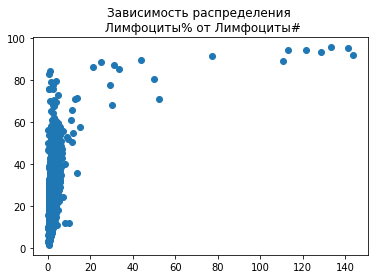

In [13]:
data = df[["Лимфоциты#_dinam_fact", "Лимфоциты%_dinam_fact"]].to_numpy()
plt.scatter(data[:,0], data[:, 1])
plt.title("Зависимость распределения \n Лимфоциты% от Лимфоциты#")

Text(0.5, 1.0, 'Распределение величины Лимфоциты#_dinam_fact')

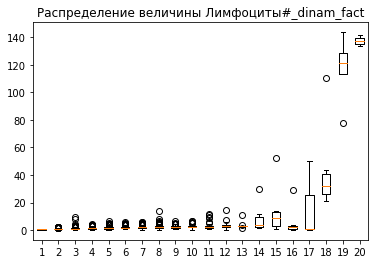

In [14]:
data = df[["Лимфоциты#_dinam_fact", "Лимфоциты%_dinam_fact"]].to_numpy()
data = [df[(df["Лимфоциты%_dinam_fact"]>i) & (df["Лимфоциты%_dinam_fact"]<i+5)]["Лимфоциты#_dinam_fact"] for i in range(0, 100, 5)]
plt.boxplot(data)
plt.title("Распределение величины Лимфоциты#_dinam_fact")

Text(0.5, 1.0, 'Распределение величины Лимфоциты%_dinam_fact')

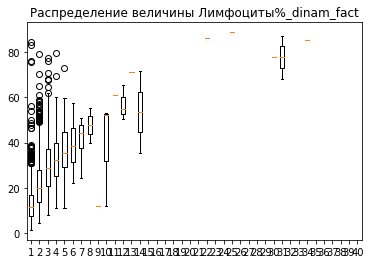

In [15]:
data = df[["Лимфоциты#_dinam_fact", "Лимфоциты%_dinam_fact"]].to_numpy()
data = [df[(df["Лимфоциты#_dinam_fact"]>i) & (df["Лимфоциты#_dinam_fact"]<i+1)]["Лимфоциты%_dinam_fact"] for i in range(0, 40, 1)]
plt.boxplot(data)
plt.title("Распределение величины Лимфоциты%_dinam_fact")

Получается, что чистой корреляции у них нет. Однако чем выше количество лимфоцитов, тем больше их часть среди других лейкоцитов. Корреляцию Пирсона получаем 0.35 (P < 1e-159)

In [16]:
from scipy.stats import pearsonr
data = df[["Лимфоциты#_dinam_fact", "Лимфоциты%_dinam_fact"]].to_numpy()
data = data[~np.isnan(data[:, 0]) & ~np.isnan(data[:, 1]) , :]
pearsonr(data[:, 0], data[:, 1])

PearsonRResult(statistic=0.35366027434981473, pvalue=5.609278436072053e-159)

Получили, что зависимость есть, но она не линейная, так что нужно оставить оба параметра

### Степень тяжести по КТ 


In [17]:
df["Cтепень тяжести по КТ_dinam_fact"].reset_index()["Cтепень тяжести по КТ_dinam_fact"].value_counts()

5    3242
2    1248
1     730
3     693
4     194
0      28
Name: Cтепень тяжести по КТ_dinam_fact, dtype: int64

Не особо понятно что такое 0 степень тяжести, такая степень 28 раз встречается. 5 - самая распространенная

Параметр является мультиклассовым, можно использовать как классификацию, так и регрессию, так как в какой то степени есть порядковый смысл между переменными

### Снижение сознания

In [18]:
df["снижение_сознания_dinam_fact"].reset_index()["снижение_сознания_dinam_fact"].value_counts()

0    5780
2     354
1       1
Name: снижение_сознания_dinam_fact, dtype: int64

Спокойно можно удалить 1, так как существует одна запись, и заменить 2 на 1. Также возможно использовать вероятности снижения сознания

## Распределения параметров

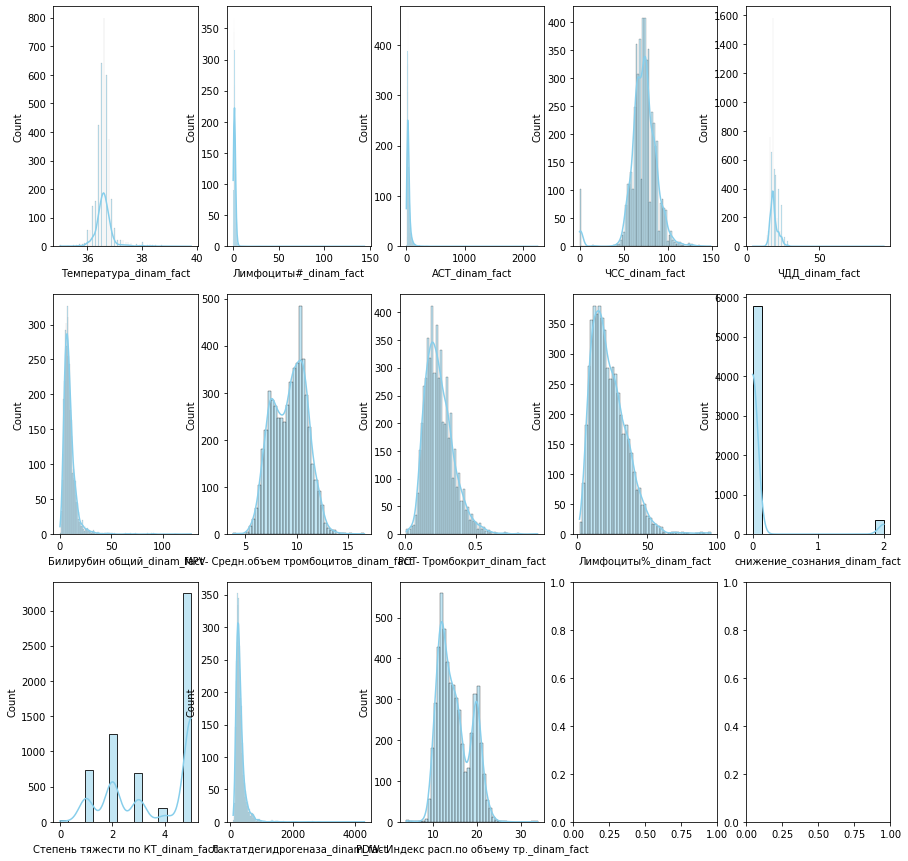

In [19]:
import seaborn as sns
figure, ax = plt.subplots(3, 5, figsize=(15, 15))
for i in range(13):
    sns.histplot(df.iloc[:, 29+i], color="skyblue", kde=True, ax=ax[i//5, i%5])

## Обучение

Теперь разделим датасет на окна - одна запись как фича, следующая за ней как таргет. И среди всех записей пациента проведем такую операцию

Выберем значения таргета без nan, и каждому из 13-ти параметров соотнесем пары - вектор параметров X и значение Y параметра на следующей неделе. 

In [20]:
def get_windows(df, window_size=2):
    X , y = [], []
    for i in df.index.levels[0]:
        try:
            for j in range(df.loc[i].index.size - window_size + 1):
                try:
                    X.append(df.loc[(i, j):(i, j+window_size-1)])
                    y.append(df.loc[(i, j+window_size)].iloc[29:42])
                except:
                    pass
        except:
            pass
    X, y = np.array(X), np.array(y)
    data = {param: [] for param in dynamic_columns}

    for i in range(len(data)):
        X_temp, y_temp = [], []
        for j in range(y.shape[0]):
            if not np.isnan(y[j][i]):
                X_temp.append(X[j])
                y_temp.append(y[j][i])
        data[dynamic_columns[i]] = {"X": np.array(X_temp), "y": np.array(y_temp)}

    return data
data = get_windows(df, 2)

In [21]:
data['Лимфоциты#_dinam_fact']["X"][3]

array([[1.00e+00, 1.00e+00, 1.00e+00, 0.00e+00, 1.00e+00, 1.00e+00,
        1.00e+00, 1.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 1.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 3.79e+01,
        7.30e-01, 2.76e+01, 6.10e+01, 2.50e+01, 5.00e+00, 1.07e+01,
        1.90e-01, 9.70e+00, 0.00e+00, 1.00e+00, 2.55e+02, 1.18e+01,
        5.90e+01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
       [1.00e+00, 1.00e+00, 1.00e+00, 0.00e+00, 1.00e+00, 1.00e+00,
        1.00e+00, 1.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 1.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 3.62e+01,
        2.04e+00,      nan, 8.40e+01, 2.00e+01,      nan, 1.03e+01,
        3.60e-01, 1.76e+01, 0.00e+00, 5.00e+00,      nan,

In [22]:
data['Лимфоциты#_dinam_fact']["y"][0]

2.13

Теперь посмотрим, сколько пар для обучения у нас присутствует

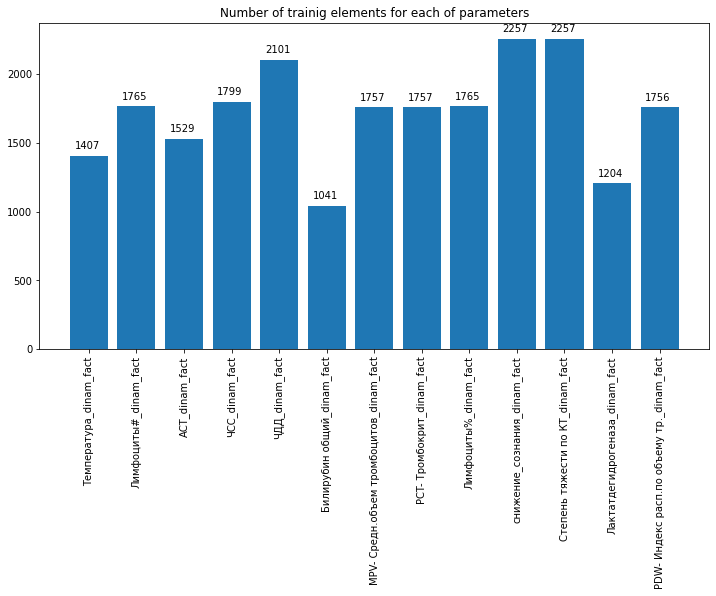

In [23]:
def get_samples_for_parameters(data):
  stat_nan = {k:len(data[k]["X"]) for k in data}
  l = stat_nan.keys()
  h = stat_nan.values()
  plt.figure(figsize=(12, 6))
  plt.bar(x=l, height=h)
  plt.xticks(rotation=90)
  plt.title("Number of trainig elements for each of parameters")
  for key_idx, key in enumerate(stat_nan):
    plt.text(key_idx-0.3,stat_nan[key]+50,stat_nan[key])

get_samples_for_parameters(data)

Нам важно измерить качество регрессии. Будем вычислять R2, MSE, mAPE и 95% интервалы этих метрик. Для доверительных интервалов будем использовать значения метрик модели на 5 фолдах (иными словами кросс валидацию) https://www.codecamp.ru/blog/confidence-intervals-python/

In [24]:
import scipy.stats as st

# Calculate R2, MSE, MAPE
def get_scores(y_real, y_pred):
    scores = {}
    scores["r2"] = r2_score(y_real, y_pred)
    scores["mse"] = mean_squared_error(y_real, y_pred)
    scores["mape"] = mean_absolute_percentage_error(y_real, y_pred)
    return scores

# Here we use composed pipeline to cross-validate it. I use 5-fold cross validation
def evaluate_with_intervals(model, X=None, y=None, folds=5, fedot=False, rnn_args={}):
    scoring_results = {"r2":[], "mape":[], "mse":[]}
    kf = KFold(folds)
    k = 0
    if (fedot):
        for train, test in tqdm(kf.split(X, y), colour="red"): 
            indata_train = InputData(idx=np.arange(0, X[train].shape[0]), 
              features=X[train],
              target=y[train],
              data_type=DataTypesEnum.table,
              task=Task(TaskTypesEnum.regression))
            model.unfit()
            model.fit(indata_train)
            indata_test = InputData(idx=np.arange(0, X[test].shape[0]), 
              features=pd.DataFrame(X[test]),
              data_type=DataTypesEnum.table,
              task=Task(TaskTypesEnum.regression))
            y_pred = model.predict(indata_test).predict
            validation_data = get_scores(y[test], y_pred)
            for sc in scoring_results:
                scoring_results[sc].append(validation_data[sc])
            k+=1
    else:
        for train, test in tqdm(kf.split(X, y), colour="red"):
            model.fit(X[train], y[train], **rnn_args)
            y_pred = model.predict(X[test])
            validation_data = get_scores( y[test], y_pred)
            for sc in scoring_results:
                scoring_results[sc].append(validation_data[sc])
            k+=1
    metrics_dataframe = {}
    for metric in scoring_results:
        scoring_result = scoring_results[metric]
        interval = st.t.interval(confidence=0.95 , df=len(scoring_result), loc=np.mean(scoring_result), scale=st.sem(scoring_result)) #95% interval
        metrics_dataframe["right_"+metric] = min(1, interval[1][0])
        metrics_dataframe["left_"+metric] = interval[0][0]
        metrics_dataframe["mean_"+metric] = ((interval[1]+interval[0])/2)[0]
    return metrics_dataframe



Чтобы обьективно понимать, что будущие модели будут улавливать закономерности а не рандомно делать свои ответы, попробуем возвращать только среднее значение параметра по всем возможным наблюдениям и после сравним эффективность такого подхода с моделью машинного обучения

### Удаление NaN

Для моделей необходимо убрать пропущенные значения. Воспользуемся простой вставкой среднего значения и IterativeImputer

In [25]:
from sklearn.linear_model import LinearRegression

class LinearRegressionClass():
    def __init__(self):
        self.scaler = StandardScaler()
        self.imputer=IterativeImputer(max_iter=50)
        self.model = LinearRegression()

    def preprocess(self, df, window=2):
        df_preprocessed = df.copy()
        self.scaler.fit(df_preprocessed.iloc[:, 29:43])
        df_preprocessed.iloc[:, 29:43] = self.scaler.transform(df_preprocessed.iloc[:, 29:43])
        self.imputer.fit(df_preprocessed.iloc[:, 29:43])
        df_preprocessed.iloc[:, 29:43] = self.imputer.transform(df_preprocessed.iloc[:, 29:43])
        data = get_windows(df_preprocessed, window)
        for i, column in enumerate(data.keys()):
            data[column]["X"] = data[column]["X"].reshape(-1, 47*window)
        return data
    
    def train(self, df, window=2):
        data = self.preprocess(df, window)
        models = {}
        for i, column in enumerate(data.keys()):
            X_vec = data[column]["X"]
            y_vec = data[column]["y"]
            models[column] = self.model.fit(X_vec, y_vec)
        return models
    
lrclass = LinearRegressionClass()
models = lrclass.train(df, 2)
models

{'Температура_dinam_fact': LinearRegression(),
 'Лимфоциты#_dinam_fact': LinearRegression(),
 'АСТ_dinam_fact': LinearRegression(),
 'ЧСС_dinam_fact': LinearRegression(),
 'ЧДД_dinam_fact': LinearRegression(),
 'Билирубин общий_dinam_fact': LinearRegression(),
 'MPV- Средн.объем тромбоцитов_dinam_fact': LinearRegression(),
 'PCT- Тромбокрит_dinam_fact': LinearRegression(),
 'Лимфоциты%_dinam_fact': LinearRegression(),
 'снижение_сознания_dinam_fact': LinearRegression(),
 'Cтепень тяжести по КТ_dinam_fact': LinearRegression(),
 'Лактатдегидрогеназа_dinam_fact': LinearRegression(),
 'PDW- Индекс расп.по объему тр._dinam_fact': LinearRegression()}

# Train models

### LinearRegression

опишем классы предобработок. Будем исплоьзовать два вида предобработки - с выстраиванием признаков недель в один вектор и взятии среднего вектора по неделям

In [26]:
from sklearn.linear_model import LinearRegression

class LinearRegressionClass():
    def __init__(self):
        self.scaler = StandardScaler()
        self.imputer=IterativeImputer(max_iter=50)
        self.model = LinearRegression()

    def preprocess(self, df, window=2):
        df_preprocessed = df.copy()
        self.scaler.fit(df_preprocessed.iloc[:, 29:43])
        df_preprocessed.iloc[:, 29:43] = self.scaler.transform(df_preprocessed.iloc[:, 29:43])
        self.imputer.fit(df_preprocessed.iloc[:, 29:43])
        df_preprocessed.iloc[:, 29:43] = self.imputer.transform(df_preprocessed.iloc[:, 29:43])
        data = get_windows(df_preprocessed, window)
        for i, column in enumerate(data.keys()):
            data[column]["X"] = data[column]["X"].reshape(-1, 47*window)
        return data
    
class LinearRegressionClassMean():
    def __init__(self):
        self.scaler = StandardScaler()
        self.imputer=IterativeImputer(max_iter=50)
        self.model = LinearRegression()

    def preprocess(self, df, window=2):
        df_preprocessed = df.copy()
        self.scaler.fit(df_preprocessed.iloc[:, 29:43])
        df_preprocessed.iloc[:, 29:43] = self.scaler.transform(df_preprocessed.iloc[:, 29:43])
        self.imputer.fit(df_preprocessed.iloc[:, 29:43])
        df_preprocessed.iloc[:, 29:43] = self.imputer.transform(df_preprocessed.iloc[:, 29:43])
        data = get_windows(df_preprocessed, window)
        for i, column in enumerate(data.keys()):
            data[column]["X"] = data[column]["X"].mean(axis=1)
        return data


И обучим модель линейной регрессии 

In [27]:
from sklearn.linear_model import LinearRegression

parameters_validation = []
lrclass = LinearRegressionClassMean()
for window in [1, 2, 3, 4, 5]: 
    data = lrclass.preprocess(df, window)
    for column in tqdm(list(data.keys())):
        X_param, y_param = data[column]["X"], data[column]["y"]
        model = LinearRegression()
        metrs = evaluate_with_intervals(model, X_param, y_param) 
        metrs["parameter"] = column
        metrs["model"] = "LinearRegression with Mean"
        metrs["window"] = window
        parameters_validation.append(metrs)
pd.DataFrame(parameters_validation).to_csv("LinearRegression_on_mean_vector.csv")


100%|██████████| 13/13 [00:00<00:00, 107.80it/s]


In [28]:
parameters_validation = []
lrclass = LinearRegressionClass()
for window in [1, 2, 3, 4, 5]: 
    data = lrclass.preprocess(df, window)
    for column in tqdm(list(data.keys())):
        X_param, y_param = data[column]["X"], data[column]["y"]
        model = LinearRegression()
        metrs = evaluate_with_intervals(model, X_param, y_param) 
        metrs["parameter"] = column
        metrs["model"] = "LinearRegression on flatten vector"
        metrs["window"] = window
        parameters_validation.append(metrs)
pd.DataFrame(parameters_validation).to_csv("LinearRegression_on_flatten_vector.csv")


100%|██████████| 13/13 [00:00<00:00, 13.17it/s]


### RNN

In [164]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU, Input, Flatten, concatenate
from keras import Model
from keras.metrics import RootMeanSquaredError


In [29]:
class RNNPreprocessClass():
    def __init__(self):
        self.scaler = StandardScaler()
        self.imputer=IterativeImputer(max_iter=50)
        self.model = LinearRegression()

    def preprocess(self, df, window=2):
        df_preprocessed = df.copy()
        self.scaler.fit(df_preprocessed.iloc[:, 29:43])
        df_preprocessed.iloc[:, 29:43] = self.scaler.transform(df_preprocessed.iloc[:, 29:43])
        self.imputer.fit(df_preprocessed.iloc[:, 29:43])
        df_preprocessed.iloc[:, 29:43] = self.imputer.transform(df_preprocessed.iloc[:, 29:43])
        data = get_windows(df_preprocessed, window)
        return data
    

In [169]:
def simple_rnn(window, params_length):
    model = Sequential(name="SimpleRNN")
    model.add(Input((window, params_length)))
    model.add(SimpleRNN(params_length, return_sequences=False))
    model.add(Dense(1, activation="linear"))
    model.compile(optimizer="adam", loss="mse")
    return model

In [55]:
def build_lstm(window, params_length):
    model = Sequential(name="LSTM")
    model.add(Input((window, params_length)))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(1, activation="linear"))
    model.compile(optimizer="adam", loss="mse")
    return model

In [ ]:
parameters_validation = []
preprocessor = RNNPreprocessClass()
for window in [1, 2, 3, 4, 5]: 
    data = preprocessor.preprocess(df, window)
    for column in tqdm(list(data.keys())):
        X_param, y_param = data[column]["X"], data[column]["y"]
        model = build_lstm(window, X_param.shape[2])
        metrs = evaluate_with_intervals(model, X_param, y_param, rnn_args={"epochs":30, "verbose":0}) 
        metrs["parameter"] = column
        metrs["model"] = "RNN Simple on windows"
        metrs["window"] = window
        parameters_validation.append(metrs)
pd.DataFrame(parameters_validation).to_csv("RNN.csv")  

In [56]:
parameters_validation = []
preprocessor = RNNPreprocessClass()
for window in [1, 2, 3, 4, 5]: 
    data = preprocessor.preprocess(df, window)
    for column in tqdm(list(data.keys())):
        X_param, y_param = data[column]["X"], data[column]["y"]
        model = build_lstm(window, X_param.shape[2])
        metrs = evaluate_with_intervals(model, X_param, y_param, rnn_args={"epochs":30, "verbose":0}) 
        metrs["parameter"] = column
        metrs["model"] = "LSTM on windows"
        metrs["window"] = window
        parameters_validation.append(metrs)
pd.DataFrame(parameters_validation).to_csv("LSTM.csv")  

  0%|          | 0/13 [00:00<?, ?it/s]

27/27 [==============================] - 0s 692us/step


  8%|▊         | 1/13 [00:18<03:44, 18.67s/it]

27/27 [==============================] - 0s 689us/step


 15%|█▌        | 2/13 [00:38<03:29, 19.07s/it]

27/27 [==============================] - 0s 690us/step


 23%|██▎       | 3/13 [00:55<03:05, 18.53s/it]

27/27 [==============================] - 0s 766us/step


 31%|███       | 4/13 [01:13<02:44, 18.23s/it]

27/27 [==============================] - 0s 690us/step


 38%|███▊      | 5/13 [01:31<02:24, 18.07s/it]

27/27 [==============================] - 0s 721us/step


 46%|████▌     | 6/13 [01:48<02:03, 17.58s/it]

27/27 [==============================] - 0s 728us/step


 54%|█████▍    | 7/13 [02:05<01:45, 17.53s/it]

27/27 [==============================] - 0s 767us/step


 62%|██████▏   | 8/13 [02:23<01:27, 17.55s/it]

27/27 [==============================] - 0s 804us/step


 69%|██████▉   | 9/13 [02:44<01:15, 18.86s/it]

27/27 [==============================] - 0s 958us/step


 77%|███████▋  | 10/13 [03:04<00:57, 19.01s/it]

27/27 [==============================] - 0s 718us/step


 85%|████████▍ | 11/13 [03:25<00:39, 19.72s/it]

27/27 [==============================] - 0s 767us/step


 92%|█████████▏| 12/13 [03:46<00:20, 20.24s/it]

27/27 [==============================] - 0s 690us/step


  0%|          | 0/13 [00:00<?, ?it/s]

15/15 [==============================] - 0s 854us/step


  8%|▊         | 1/13 [00:15<03:01, 15.10s/it]

15/15 [==============================] - 0s 925us/step


 15%|█▌        | 2/13 [00:30<02:49, 15.44s/it]

15/15 [==============================] - 0s 854us/step


 23%|██▎       | 3/13 [00:45<02:32, 15.28s/it]

15/15 [==============================] - 0s 881us/step


 31%|███       | 4/13 [01:00<02:15, 15.06s/it]

15/15 [==============================] - 0s 997us/step


 38%|███▊      | 5/13 [01:14<01:56, 14.59s/it]

15/15 [==============================] - 0s 854us/step


 46%|████▌     | 6/13 [01:28<01:41, 14.48s/it]

15/15 [==============================] - 0s 909us/step


 54%|█████▍    | 7/13 [01:43<01:27, 14.59s/it]

15/15 [==============================] - 0s 828us/step


 62%|██████▏   | 8/13 [01:56<01:10, 14.15s/it]

15/15 [==============================] - 0s 1ms/step


 69%|██████▉   | 9/13 [02:14<01:01, 15.42s/it]

15/15 [==============================] - 0s 1ms/step


 77%|███████▋  | 10/13 [02:30<00:46, 15.55s/it]

15/15 [==============================] - 0s 1ms/step


 85%|████████▍ | 11/13 [02:45<00:30, 15.38s/it]

15/15 [==============================] - 0s 926us/step


 92%|█████████▏| 12/13 [03:02<00:15, 15.90s/it]

15/15 [==============================] - 0s 997us/step


  0%|          | 0/13 [00:00<?, ?it/s]

6/6 [==============================] - 0s 2ms/step


  8%|▊         | 1/13 [00:07<01:34,  7.88s/it]

6/6 [==============================] - 0s 2ms/step


 15%|█▌        | 2/13 [00:18<01:41,  9.27s/it]

6/6 [==============================] - 0s 1ms/step


 23%|██▎       | 3/13 [00:27<01:33,  9.39s/it]

6/6 [==============================] - 0s 1ms/step


 31%|███       | 4/13 [00:36<01:22,  9.18s/it]

6/6 [==============================] - 0s 1ms/step


 38%|███▊      | 5/13 [00:45<01:11,  8.99s/it]

6/6 [==============================] - 0s 1ms/step


 46%|████▌     | 6/13 [00:52<01:00,  8.59s/it]

6/6 [==============================] - 0s 1ms/step


 54%|█████▍    | 7/13 [01:00<00:50,  8.39s/it]

6/6 [==============================] - 0s 1ms/step


 62%|██████▏   | 8/13 [01:08<00:40,  8.19s/it]

6/6 [==============================] - 0s 2ms/step


 69%|██████▉   | 9/13 [01:18<00:34,  8.61s/it]

6/6 [==============================] - 0s 2ms/step


 77%|███████▋  | 10/13 [01:27<00:26,  8.86s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████▍ | 11/13 [01:37<00:18,  9.01s/it]

6/6 [==============================] - 0s 1ms/step


 92%|█████████▏| 12/13 [01:45<00:08,  8.82s/it]

6/6 [==============================] - 0s 2ms/step


  0%|          | 0/13 [00:00<?, ?it/s]

3/3 [==============================] - 0s 1ms/step


  8%|▊         | 1/13 [00:04<00:56,  4.68s/it]

3/3 [==============================] - 0s 2ms/step


 15%|█▌        | 2/13 [00:08<00:46,  4.25s/it]

3/3 [==============================] - 0s 1ms/step


 23%|██▎       | 3/13 [00:12<00:41,  4.13s/it]

3/3 [==============================] - 0s 2ms/step


 31%|███       | 4/13 [00:16<00:36,  4.11s/it]

3/3 [==============================] - 0s 2ms/step


 38%|███▊      | 5/13 [00:21<00:34,  4.31s/it]

3/3 [==============================] - 0s 3ms/step


 46%|████▌     | 6/13 [00:25<00:30,  4.37s/it]

3/3 [==============================] - 0s 2ms/step


 54%|█████▍    | 7/13 [00:30<00:26,  4.35s/it]

3/3 [==============================] - 0s 1ms/step


 62%|██████▏   | 8/13 [00:34<00:21,  4.40s/it]

3/3 [==============================] - 0s 1ms/step


 69%|██████▉   | 9/13 [00:38<00:17,  4.37s/it]

3/3 [==============================] - 0s 2ms/step


 77%|███████▋  | 10/13 [00:42<00:12,  4.26s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████▍ | 11/13 [00:47<00:08,  4.28s/it]

3/3 [==============================] - 0s 1ms/step


 92%|█████████▏| 12/13 [00:51<00:04,  4.24s/it]

3/3 [==============================] - 0s 2ms/step


  0%|          | 0/13 [00:00<?, ?it/s]

2/2 [==============================] - 0s 3ms/step


  8%|▊         | 1/13 [00:04<00:49,  4.15s/it]

2/2 [==============================] - 0s 4ms/step


 15%|█▌        | 2/13 [00:07<00:43,  3.92s/it]

2/2 [==============================] - 0s 2ms/step


 23%|██▎       | 3/13 [00:11<00:37,  3.79s/it]

2/2 [==============================] - 0s 3ms/step


 31%|███       | 4/13 [00:15<00:34,  3.79s/it]

2/2 [==============================] - 0s 5ms/step


 38%|███▊      | 5/13 [00:19<00:30,  3.81s/it]

2/2 [==============================] - 0s 2ms/step


 46%|████▌     | 6/13 [00:22<00:26,  3.76s/it]

2/2 [==============================] - 0s 2ms/step


 54%|█████▍    | 7/13 [00:26<00:22,  3.75s/it]

2/2 [==============================] - 0s 2ms/step


 62%|██████▏   | 8/13 [00:29<00:18,  3.64s/it]

2/2 [==============================] - 0s 2ms/step


 69%|██████▉   | 9/13 [00:34<00:15,  3.99s/it]

2/2 [==============================] - 0s 2ms/step


 77%|███████▋  | 10/13 [00:38<00:11,  3.89s/it]

2/2 [==============================] - 0s 2ms/step


 85%|████████▍ | 11/13 [00:42<00:07,  3.83s/it]

2/2 [==============================] - 0s 2ms/step


 92%|█████████▏| 12/13 [00:45<00:03,  3.85s/it]

2/2 [==============================] - 0s 3ms/step


100%|██████████| 13/13 [00:50<00:00,  3.85s/it]


### HistGradientBoostingRegressor

Сделаем модели на каждый параметр с простенькой моделью HistGradientBoostingRegressor (она единственная из sklearn ргегрессоров поддерживает NaN)

In [ ]:
class HistGradientBoostingRegressorPreprocessor():
    def preprocess(self, df, window=2):
        data = get_windows(df.copy(), window)
        for i, column in enumerate(data.keys()):
            data[column]["X"] = data[column]["X"].reshape(-1, 47*window)
        return data

In [31]:
from sklearn.ensemble import HistGradientBoostingRegressor
parameters_validation = []
preprocessor = HistGradientBoostingRegressorPreprocessor()
for window in [1, 2, 3, 4, 5]: 
    data = preprocessor.preprocess(df, window)
    for column in tqdm(list(data.keys())):
        X_param, y_param = data[column]["X"], data[column]["y"]
        model = HistGradientBoostingRegressor()
        metrs = evaluate_with_intervals(model, X_param, y_param) 
        metrs["parameter"] = column
        metrs["model"] = "HistGradientBoostingRegressor on flat vector"
        metrs["window"] = window   
        parameters_validation.append(metrs)
pd.DataFrame(parameters_validation).to_csv("HistGradientBoostingRegressor_on_flat_vector.csv")


100%|██████████| 13/13 [00:31<00:00,  2.40s/it]


### Fedot

Построим пайплайны с помощью Fedot на каждый из параметров. 

Будем использовать таймаут 10 минут, так как при дальнейшем продолжении композиции качество не увеличивается на все параметрах

In [63]:
def build_fedot():
    model = Fedot(problem="regression", timeout=10, cache_folder="D:\\Cache") # I changed cache folder path as it tkaes up to 20Gb
    return model

In [66]:
class FedotPreprocessor():
    def preprocess(self, df, window=2):
        data = get_windows(df.copy(), window)
        for i, column in enumerate(data.keys()):
            data[column]["X"] = data[column]["X"].reshape(-1, 47*window)
        return data

И построенные пайплайны с тюнеными параметрами оцениваем кросс-валидацией на тех же данных, что и строили


In [67]:
parameters_validation = []
preprocessor = FedotPreprocessor()
for window in [1, 2, 3, 4, 5]: 
    data = preprocessor.preprocess(df, window)
    pipelines_saved = {}
    for col in list(data.keys()):
        print(f"Start composing Fedot pipeline {col}, window size {window}")
        model = build_fedot()
        X_param, y_param = data[col]["X"], data[col]["y"]
        pipeline = model.fit(X_param, y_param)
        pipelines_saved[col] = pipeline
        pipeline.save(f"fedot_pipelines\\window_{window}\\{col}", create_subdir=False, is_datetime_in_path=False)
        print(f"Successfully composed {col} \n")
    print("Start cross validation")
    for column in tqdm(list(data.keys())):
        X_param, y_param = data[column]["X"], data[column]["y"]
        model = pipelines_saved[col]
        metrs = evaluate_with_intervals(model, X_param, y_param, fedot=True) 
        metrs["parameter"] = column
        metrs["model"] = "Fedot"
        metrs["window"] = window   
        parameters_validation.append(metrs)
pd.DataFrame(parameters_validation).to_csv("Fedot_on_flat_vector.csv")


Start composing Fedot pipeline Температура_dinam_fact, window size 1
2023-06-20 00:20:59,955 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 124.7 MiB, max: 140.0 MiB
2023-06-20 00:20:59,958 - ApiComposer - Initial pipeline was fitted in 2.5 sec.
2023-06-20 00:20:59,960 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2023-06-20 00:20:59,969 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 10 min. Set of candidate models: ['isolation_forest_reg', 'gbr', 'svr', 'knnreg', 'dtreg', 'pca', 'ransac_lin_reg', 'poly_features', 'fast_ica', 'adareg', 'sgdr', 'ridge', 'rfr', 'treg', 'scaling', 'ransac_non_lin_reg', 'lgbmreg', 'lasso', 'normalization', 'linear', 'isolation_forest_reg', 'gbr', 'svr', 'knnreg', 'dtreg', 'pca', 'ransac_lin_reg', 'poly_features', 'fast_ica', 'adareg', 'sgdr', 'ridge', 'rfr', 'treg', 'scaling', 'ransac_non_lin_reg', 'lgbmreg', 'lasso', '

Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2023-06-20 00:21:10,255 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-06-20 00:22:32,269 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-06-20 00:23:02,471 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-06-20 00:23:46,207 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-06-20 00:25:04,367 - MultiprocessingDispatcher - 32 individuals out of 32 in previous population were evaluated successfully.
2023-06-20 00:26:24,136 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2023-06-20 00:26:24,166 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 1/10000 [05:24<?, ?gen/s]

2023-06-20 00:26:24,185 - ApiComposer - Hyperparameters tuning started with 5 min. timeout


2023-06-20 00:26:35,341 - SimultaneousTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [rfr, normalization]}
rfr - {'n_jobs': 1, 'max_features': 0.056908430229687695, 'min_samples_split': 7, 'min_samples_leaf': 16, 'bootstrap': True}
normalization - {} 
Initial metric: 0.256
  0%|          | 20/100000 [04:03<355:20:11, 12.79s/trial, best loss: 0.2561144544764492]
2023-06-20 00:30:58,016 - SimultaneousTuner - Final graph: {'depth': 2, 'length': 2, 'nodes': [rfr, normalization]}
rfr - {'n_jobs': 1, 'max_features': 0.056908430229687695, 'min_samples_split': 7, 'min_samples_leaf': 16, 'bootstrap': True}
normalization - {}
2023-06-20 00:30:58,018 - SimultaneousTuner - Final metric: 0.256
2023-06-20 00:30:58,022 - ApiComposer - Hyperparameters tuning finished
2023-06-20 00:30:58,557 - ApiComposer - Model generation finished
2023-06-20 00:30:59,770 - FEDOT logger - Final pipeline was fitted
2023-06-20 00:30:59,772 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [r

Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2023-06-20 00:31:10,775 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-06-20 00:32:51,617 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-06-20 00:33:25,751 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-06-20 00:33:33,850 - MultiprocessingDispatcher - 12 individuals out of 12 in previous population were evaluated successfully.
2023-06-20 00:33:42,633 - MultiprocessingDispatcher - 12 individuals out of 12 in previous population were evaluated successfully.
2023-06-20 00:34:04,685 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-06-20 00:34:23,976 - MultiprocessingDispatcher - 32 individuals out of 32 in previous population were evaluated successfully.
2023-06-20 00:35:07,800 - MultiprocessingDispatcher - 54 individuals out of 54 in pre

Generations:   0%|          | 1/10000 [05:58<?, ?gen/s]

2023-06-20 00:37:03,661 - ApiComposer - Hyperparameters tuning started with 4 min. timeout


2023-06-20 00:37:15,541 - SimultaneousTuner - Initial graph: {'depth': 3, 'length': 3, 'nodes': [gbr, treg, scaling]}
gbr - {}
treg - {'max_features': 0.9092317395971324, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False}
scaling - {} 
Initial metric: 2.796
 50%|█████     | 5/10 [01:32<01:30, 18.13s/trial, best loss: 4.114967174339948]

C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_gb.py:301: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  warnings.warn(

C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_gb.py:301: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  warnings.warn(

C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_gb.py:301: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  warnings.warn(

C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_gb.py:301: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  warnings.warn(

C:\Users\sirau\AppData\Roaming\Python\Py

 60%|██████    | 6/10 [01:53<01:15, 18.90s/trial, best loss: 4.114967174339948]

C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_gb.py:294: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(

C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_gb.py:294: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(

C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_gb.py:294: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(

C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_gb.py:294: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(

C:\Users\sirau\AppData\Roaming\Python\Python310\

 90%|█████████ | 9/10 [02:31<00:14, 14.91s/trial, best loss: 4.114967174339948]

C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_gb.py:294: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(

C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_gb.py:294: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(

C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_gb.py:294: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(

C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_gb.py:294: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(

C:\Users\sirau\AppData\Roaming\Python\Python310\

  0%|          | 11/100000 [00:30<847:06:44, 30.50s/trial, best loss: 4.114967174339948]

C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_gb.py:301: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  warnings.warn(

C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_gb.py:301: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  warnings.warn(

C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_gb.py:301: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  warnings.warn(

C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_gb.py:301: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  warnings.warn(

C:\Users\sirau\AppData\Roaming\Python\Py

  0%|          | 12/100000 [00:43<560:15:37, 20.17s/trial, best loss: 4.114967174339948]

C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_gb.py:301: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  warnings.warn(

C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_gb.py:301: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  warnings.warn(

C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_gb.py:301: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  warnings.warn(

C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_gb.py:301: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  warnings.warn(

C:\Users\sirau\AppData\Roaming\Python\Py

  0%|          | 13/100000 [01:06<617:20:19, 22.23s/trial, best loss: 4.114967174339948]
2023-06-20 00:41:20,173 - SimultaneousTuner - Final graph: {'depth': 3, 'length': 3, 'nodes': [gbr, treg, scaling]}
gbr - {}
treg - {'max_features': 0.9092317395971324, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False}
scaling - {}
2023-06-20 00:41:20,176 - SimultaneousTuner - Final metric: 2.796
2023-06-20 00:41:20,180 - ApiComposer - Hyperparameters tuning finished
2023-06-20 00:41:20,465 - ApiComposer - Model generation finished
2023-06-20 00:41:23,132 - FEDOT logger - Final pipeline was fitted
2023-06-20 00:41:23,133 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 3, 'nodes': [gbr, treg, scaling]}
gbr - {}
treg - {'max_features': 0.9092317395971324, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False}
scaling - {}
Memory consumption for finish in main session: current 9.7 MiB, max: 38.6 MiB
Successfully composed Лимфоциты#_dinam_fact 

Start composing Fedo

Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2023-06-20 00:41:54,691 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-06-20 00:43:03,674 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-06-20 00:43:42,159 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-06-20 00:43:54,997 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-06-20 00:44:16,267 - MultiprocessingDispatcher - 32 individuals out of 32 in previous population were evaluated successfully.
2023-06-20 00:45:53,919 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2023-06-20 00:47:12,212 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2023-06-20 00:47:12,228 - GroupedCondition - Optimisation stopped: Time limit is reac

Generations:   0%|          | 1/10000 [05:21<?, ?gen/s]

2023-06-20 00:47:12,236 - ApiComposer - Hyperparameters tuning started with 5 min. timeout


2023-06-20 00:47:15,417 - SimultaneousTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [lasso, scaling]}
lasso - {'alpha': 6.855016002684591}
scaling - {} 
Initial metric: 78.622
  0%|          | 73/100000 [04:26<102:49:21,  3.70s/trial, best loss: 78.62199405588366]
2023-06-20 00:51:49,634 - SimultaneousTuner - Final graph: {'depth': 2, 'length': 2, 'nodes': [lasso, scaling]}
lasso - {'alpha': 6.855016002684591}
scaling - {}
2023-06-20 00:51:49,639 - SimultaneousTuner - Final metric: 78.622
2023-06-20 00:51:49,643 - ApiComposer - Hyperparameters tuning finished
2023-06-20 00:51:49,958 - ApiComposer - Model generation finished
2023-06-20 00:51:50,787 - FEDOT logger - Final pipeline was fitted
2023-06-20 00:51:50,788 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [lasso, scaling]}
lasso - {'alpha': 6.855016002684591}
scaling - {}
Memory consumption for finish in main session: current 8.3 MiB, max: 34.3 MiB
Successfully composed АСТ_dinam_fact 

Start compos

Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2023-06-20 00:52:27,174 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-06-20 00:53:47,935 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-06-20 00:54:14,249 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-06-20 00:54:39,957 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-06-20 00:55:12,119 - MultiprocessingDispatcher - 32 individuals out of 32 in previous population were evaluated successfully.
2023-06-20 00:56:05,837 - MultiprocessingDispatcher - 32 individuals out of 32 in previous population were evaluated successfully.
2023-06-20 00:56:57,613 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2023-06-20 00:58:26,859 - MultiprocessingDispatcher - 54 individuals out of 54 in pre

Generations:   0%|          | 1/10000 [06:11<?, ?gen/s]

2023-06-20 00:58:26,885 - ApiComposer - Hyperparameters tuning started with 4 min. timeout


2023-06-20 00:58:34,225 - SimultaneousTuner - Initial graph: {'depth': 3, 'length': 3, 'nodes': [rfr, lasso, scaling]}
rfr - {'n_jobs': 1}
lasso - {}
scaling - {} 
Initial metric: 16.082
  0%|          | 31/100000 [03:35<192:44:59,  6.94s/trial, best loss: 16.082221304227737]
2023-06-20 01:02:16,766 - SimultaneousTuner - Final graph: {'depth': 3, 'length': 3, 'nodes': [rfr, lasso, scaling]}
rfr - {'n_jobs': 1}
lasso - {}
scaling - {}
2023-06-20 01:02:16,768 - SimultaneousTuner - Final metric: 16.082
2023-06-20 01:02:16,773 - ApiComposer - Hyperparameters tuning finished
2023-06-20 01:02:17,143 - ApiComposer - Model generation finished
2023-06-20 01:02:18,762 - FEDOT logger - Final pipeline was fitted
2023-06-20 01:02:18,765 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 3, 'nodes': [rfr, lasso, scaling]}
rfr - {'n_jobs': -1}
lasso - {}
scaling - {}
Memory consumption for finish in main session: current 8.9 MiB, max: 33.7 MiB
Successfully composed ЧСС_dinam_fact 

Start composi

Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2023-06-20 01:02:39,849 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-06-20 01:04:33,685 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-06-20 01:06:15,387 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-06-20 01:06:29,745 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-06-20 01:07:08,844 - MultiprocessingDispatcher - 32 individuals out of 32 in previous population were evaluated successfully.
2023-06-20 01:08:39,182 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2023-06-20 01:08:39,198 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 1/10000 [06:04<?, ?gen/s]

2023-06-20 01:08:39,207 - ApiComposer - Hyperparameters tuning started with 4 min. timeout


2023-06-20 01:08:47,002 - SimultaneousTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [rfr, scaling]}
rfr - {'n_jobs': 1, 'max_features': 0.05885844474664863, 'min_samples_split': 4, 'min_samples_leaf': 6, 'bootstrap': False}
scaling - {} 
Initial metric: 2.314
  0%|          | 18/100000 [03:29<342:32:05, 12.33s/trial, best loss: 2.314262480579501]
2023-06-20 01:12:32,436 - SimultaneousTuner - Final graph: {'depth': 2, 'length': 2, 'nodes': [rfr, scaling]}
rfr - {'n_jobs': 1, 'max_features': 0.05885844474664863, 'min_samples_split': 4, 'min_samples_leaf': 6, 'bootstrap': False}
scaling - {}
2023-06-20 01:12:32,441 - SimultaneousTuner - Final metric: 2.314
2023-06-20 01:12:32,445 - ApiComposer - Hyperparameters tuning finished
2023-06-20 01:12:32,770 - ApiComposer - Model generation finished
2023-06-20 01:12:34,355 - FEDOT logger - Final pipeline was fitted
2023-06-20 01:12:34,357 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [rfr, scaling]}
rfr - {'n_job

Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2023-06-20 01:12:43,012 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-06-20 01:13:57,562 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-06-20 01:14:49,796 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-06-20 01:15:00,434 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-06-20 01:15:39,712 - MultiprocessingDispatcher - 32 individuals out of 32 in previous population were evaluated successfully.
2023-06-20 01:16:13,953 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2023-06-20 01:16:59,750 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2023-06-20 01:17:52,483 - MultiprocessingDispatcher - 54 individuals out of 54 in pre

Generations:   0%|          | 1/10000 [06:27<?, ?gen/s]

2023-06-20 01:19:06,957 - ApiComposer - Hyperparameters tuning started with 3 min. timeout


2023-06-20 01:19:55,352 - SimultaneousTuner - Initial graph: {'depth': 3, 'length': 3, 'nodes': [rfr, scaling, fast_ica]}
rfr - {'n_jobs': 1, 'max_features': 0.957011372367486, 'min_samples_split': 4, 'min_samples_leaf': 10, 'bootstrap': True}
scaling - {}
fast_ica - {'whiten': 'unit-variance'} 
Initial metric: 7.393
100%|██████████| 10/10 [02:13<00:00, 13.39s/trial, best loss: 7.414267581255865]
2023-06-20 01:22:09,300 - SimultaneousTuner - Tunner stopped after initial search due to the lack of time
2023-06-20 01:22:09,308 - ApiComposer - Hyperparameters tuning finished
2023-06-20 01:22:09,744 - ApiComposer - Model generation finished
2023-06-20 01:22:12,852 - FEDOT logger - Final pipeline was fitted
2023-06-20 01:22:12,854 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 3, 'nodes': [rfr, scaling, fast_ica]}
rfr - {'n_jobs': -1, 'max_features': 0.957011372367486, 'min_samples_split': 4, 'min_samples_leaf': 10, 'bootstrap': True}
scaling - {}
fast_ica - {'whiten': 'unit-varianc

Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2023-06-20 01:22:23,595 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-06-20 01:23:43,720 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-06-20 01:25:05,133 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-06-20 01:26:33,583 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-06-20 01:27:01,830 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-06-20 01:29:09,442 - MultiprocessingDispatcher - 32 individuals out of 32 in previous population were evaluated successfully.
2023-06-20 01:29:09,458 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 1/10000 [06:50<?, ?gen/s]

2023-06-20 01:29:09,469 - ApiComposer - Hyperparameters tuning started with 3 min. timeout


2023-06-20 01:30:22,227 - SimultaneousTuner - Initial graph: {'depth': 3, 'length': 3, 'nodes': [rfr, fast_ica, scaling]}
rfr - {'n_jobs': 1}
fast_ica - {'whiten': 'unit-variance'}
scaling - {} 
Initial metric: 1.604
  0%|          | 4/100000 [00:51<356:37:15, 12.84s/trial, best loss: 1.649852313299337]
2023-06-20 01:31:23,924 - SimultaneousTuner - Final graph: {'depth': 3, 'length': 3, 'nodes': [rfr, fast_ica, scaling]}
rfr - {'n_jobs': 1}
fast_ica - {'whiten': 'unit-variance'}
scaling - {}
2023-06-20 01:31:23,926 - SimultaneousTuner - Final metric: 1.604
2023-06-20 01:31:23,930 - ApiComposer - Hyperparameters tuning finished
2023-06-20 01:31:24,256 - ApiComposer - Model generation finished
2023-06-20 01:31:42,255 - FEDOT logger - Final pipeline was fitted
2023-06-20 01:31:42,257 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 3, 'nodes': [rfr, fast_ica, scaling]}
rfr - {'n_jobs': -1}
fast_ica - {'whiten': 'unit-variance'}
scaling - {}
Memory consumption for finish in main ses

Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2023-06-20 01:31:53,670 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-06-20 01:33:19,364 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-06-20 01:35:04,010 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-06-20 01:35:18,900 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-06-20 01:36:18,863 - MultiprocessingDispatcher - 32 individuals out of 32 in previous population were evaluated successfully.
2023-06-20 01:37:15,976 - MultiprocessingDispatcher - 54 individuals out of 54 in previous population were evaluated successfully.
2023-06-20 01:37:15,992 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 1/10000 [05:27<?, ?gen/s]

2023-06-20 01:37:16,001 - ApiComposer - Hyperparameters tuning started with 4 min. timeout


2023-06-20 01:37:23,105 - SimultaneousTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [rfr, normalization]}
rfr - {'n_jobs': 1, 'max_features': 0.07877333391524474, 'min_samples_split': 7, 'min_samples_leaf': 16, 'bootstrap': True}
normalization - {} 
Initial metric: 0.105
  0%|          | 25/100000 [04:11<291:25:15, 10.49s/trial, best loss: 0.10474436759712155]
2023-06-20 01:41:49,651 - SimultaneousTuner - Final graph: {'depth': 2, 'length': 2, 'nodes': [rfr, normalization]}
rfr - {'n_jobs': 1, 'max_features': 0.08405206523037131, 'min_samples_split': 20, 'min_samples_leaf': 7, 'bootstrap': False}
normalization - {}
2023-06-20 01:41:49,657 - SimultaneousTuner - Final metric: 0.105
2023-06-20 01:41:49,660 - ApiComposer - Hyperparameters tuning finished
2023-06-20 01:41:50,006 - ApiComposer - Model generation finished
2023-06-20 01:41:51,595 - FEDOT logger - Final pipeline was fitted
2023-06-20 01:41:51,597 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [r

Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2023-06-20 01:42:03,454 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.


# Analytics

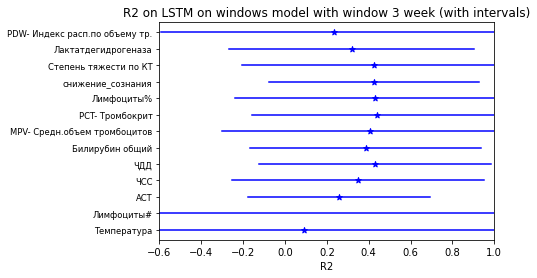

In [62]:
import numpy as np
def draw_stat_with_intervals(statistics_df, window=1):
    pldata = statistics_df[statistics_df["window"]==window][["right_r2", "left_r2", "mean_r2", "parameter", "model"]]
    psnames = [i[:len(i)-11] for i in pldata["parameter"]]
    for i in range(pldata.shape[0]):
        plt.plot(pldata.iloc[i, 0:2], [i, i], c="blue")
        plt.scatter(pldata.iloc[i, 2], [i], c="blue", marker="*")
    plt.title(f"R2 on {pldata['model'].iloc[0]} model with window {window} week (with intervals)")
    plt.xlabel("R2")
    plt.yticks(range(len(psnames)), psnames , size='small')
    plt.xlim((-0.6, 1))
    plt.show()
    plt.savefig(f"R2 on {pldata['model'].iloc[0]} model with window {window} week (with intervals).png")

linear_regression_stat_df = pd.read_csv("D:\\covid\\covid\\test.csv")
draw_stat_with_intervals(linear_regression_stat_df, 1)


In [134]:
tdf = hm2
tdf[["parameter", "min_r2", "max_r2", "avg_r2"]].set_index("parameter")
tdf.loc[tdf[tdf["max_r2"]>1].index, "max_r2"] = 1
tdf[["parameter", "min_r2", "max_r2", "avg_r2"]].set_index("parameter")

,min_r2,max_r2,avg_r2
parameter,,,
Температура_dinam_fact,-0.164567,-0.102006,-0.133286
Лимфоциты#_dinam_fact,-1.931608,0.726916,-0.602346
АСТ_dinam_fact,-8.340363,1.000000,-2.895814
ЧСС_dinam_fact,-0.115900,-0.042868,-0.079384
ЧДД_dinam_fact,-0.036888,0.123931,0.043521
Билирубин общий_dinam_fact,0.149049,0.505674,0.327361
MPV- Средн.объем тромбоцитов_dinam_fact,0.493816,0.881919,0.687867
PCT- Тромбокрит_dinam_fact,0.280609,0.433798,0.357204
Лимфоциты%_dinam_fact,0.336276,0.496436,0.416356


In [ ]:
tdf[tdf["max_r2"]>1]

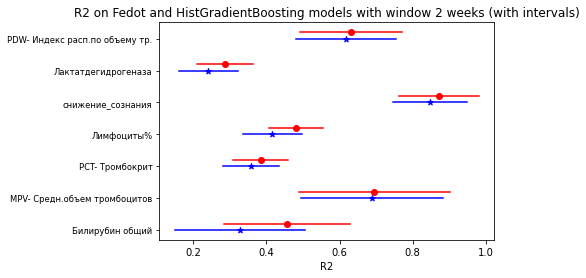

In [190]:
tdf = hm2
pldata = tdf[(tdf["max_r2"]>0.1) & (tdf["min_r2"]>0.1)][["max_r2", "min_r2", "avg_r2", "parameter", "model"]]
psnames = [i[:len(i)-11] for i in pldata["parameter"]]
for i in range(pldata.shape[0]):
    plt.plot(pldata.iloc[i, 0:2], [i, i], c="blue")
    plt.scatter(pldata.iloc[i, 2], [i], c="blue", marker="*")


tdf = fm2
pldata = tdf[(tdf["max_r2"]>0.1) & (tdf["min_r2"]>0.1)][["max_r2", "min_r2", "avg_r2", "parameter", "model"]]
psnames = [i[:len(i)-11] for i in pldata["parameter"]]
for i in range(pldata.shape[0]):
    plt.plot(pldata.iloc[i, 0:2], [i+0.2, i+0.2], c="red")
    plt.scatter(pldata.iloc[i, 2], [i+0.2], c="red", marker="o")
plt.title("R2 on Fedot and HistGradientBoosting models with window 2 weeks (with intervals)")
plt.xlabel("R2")
plt.yticks(range(len(psnames)), psnames , size='small')
plt.xlim()
plt.show()

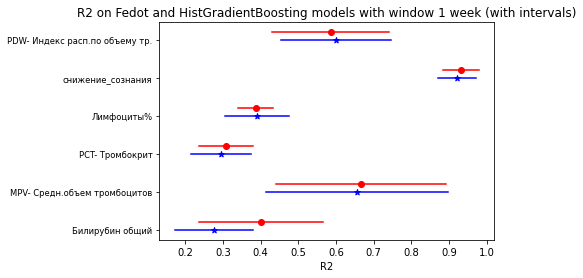

In [182]:
tdf = hm
pldata = tdf[(tdf["max_r2"]>0.1) & (tdf["min_r2"]>0.1)][["max_r2", "min_r2", "avg_r2", "parameter", "model"]]
psnames = [i[:len(i)-11] for i in pldata["parameter"]]
for i in range(pldata.shape[0]):
    plt.plot(pldata.iloc[i, 0:2], [i, i], c="blue")
    plt.scatter(pldata.iloc[i, 2], [i], c="blue", marker="*")


tdf = fm
pldata = tdf[(tdf["max_r2"]>0.1) & (tdf["min_r2"]>0.1)][["max_r2", "min_r2", "avg_r2", "parameter", "model"]]
psnames = [i[:len(i)-11] for i in pldata["parameter"]]
for i in range(pldata.shape[0]):
    plt.plot(pldata.iloc[i, 0:2], [i+0.2, i+0.2], c="red")
    plt.scatter(pldata.iloc[i, 2], [i+0.2], c="red", marker="o")
plt.title("R2 on Fedot and HistGradientBoosting models with window 1 week (with intervals)")
plt.xlabel("R2")
plt.yticks(range(len(psnames)), psnames , size='small')
plt.xlim()
plt.show()

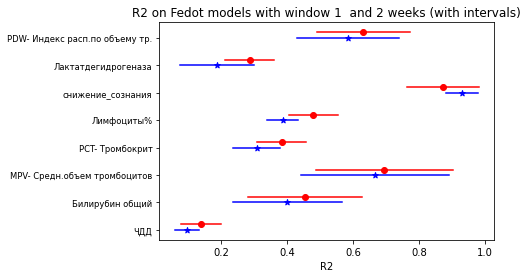

In [200]:
tdf = fm
pldata = tdf[(tdf["max_r2"]>0) & (tdf["min_r2"]>0)][["max_r2", "min_r2", "avg_r2", "parameter", "model"]]
psnames = [i[:len(i)-11] for i in pldata["parameter"]]
for i in range(pldata.shape[0]):
    plt.plot(pldata.iloc[i, 0:2], [i, i], c="blue")
    plt.scatter(pldata.iloc[i, 2], [i], c="blue", marker="*")


tdf = fm2
pldata = tdf[(tdf["max_r2"]>0) & (tdf["min_r2"]>0)][["max_r2", "min_r2", "avg_r2", "parameter", "model"]]
psnames = [i[:len(i)-11] for i in pldata["parameter"]]
for i in range(pldata.shape[0]):
    plt.plot(pldata.iloc[i, 0:2], [i+0.2, i+0.2], c="red")
    plt.scatter(pldata.iloc[i, 2], [i+0.2], c="red", marker="o")
plt.title("R2 on Fedot models with window 1  and 2 weeks (with intervals)")
plt.xlabel("R2")
plt.yticks(range(len(psnames)), psnames , size='small')
plt.xlim()
plt.show()